# RAG LLM 

## The Setup

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from pdfminer.high_level import extract_text
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_pinecone import PineconeVectorStore
import warnings
warnings.filterwarnings("ignore")

## Credentials

In [2]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

## Model

In [3]:
model = ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-3.5-turbo")
parser = StrOutputParser()
chain = model | parser
chain.invoke("hi, are you there gpt?")

"Hello! Yes, I'm here. How can I assist you today?"

## Plug and Play Context 🚩

### PDF to Txt

In [4]:
def pdf_to_text(pdf_path, output_txt_path):
    text = extract_text(pdf_path)
    with open(output_txt_path, 'w', encoding='utf-8') as file:
        file.write(text)

In [5]:
pdf_path = '../files/Computer Age Statistical Inference Book.pdf'
output_txt_path = '../files/Computer Age Statistical Inference Book.txt'  
# pdf_to_text(pdf_path, output_txt_path)

### Chunking Context for LLM 

In [6]:
loader = TextLoader("../files/Computer Age Statistical Inference Book.txt")
text_documents = loader.load()

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
documents = text_splitter.split_documents(text_documents)
print(documents[:2])

[Document(page_content='The Work, Computer Age Statistical Inference, was ﬁrst published by Cambridge University Press.\nc(cid:13) in the Work, Bradley Efron and Trevor Hastie, 2016.\nCambridge University Press’s catalogue entry for the Work can be found at http: // www. cambridge. org/\n9781107149892\nNB: The copy of the Work, as displayed on this website, can be purchased through Cambridge University\nPress and other standard distribution channels. This copy is made available for personal use only and must\nnot be adapted, sold or re-distributed.\nCorrected November 10, 2017.', metadata={'source': '../files/Computer Age Statistical Inference Book.txt'}), Document(page_content='The twenty-first century has seen a breathtaking expansion of statistical methodology, both in scope and in influence. “Big data,” “data science,” and “machine learning” have become familiar terms in the news, as statistical methods are brought to bear upon the enormous data sets of modern science and commerce.

## Embedding Context 

In [8]:
embeddings = OpenAIEmbeddings()
vector_store = DocArrayInMemorySearch.from_documents(documents, embeddings)

In [9]:
retriever = vector_store.as_retriever()
retriever.invoke("Who or what do frequentists criticize?") # the pdf to text is garbage ... but great use case! 🤣

[Document(page_content='What might be called the strong deﬁnition of frequentism insists on exact\nfrequentist correctness under experimental repetitions. Pivotality, unfortu-\nnately, is unavailable in most statistical situations. Our looser deﬁnition\nof frequentism, supplemented by devices such as those above,7 presents a\nmore realistic picture of actual frequentist practice.\n\n2.2 Frequentist Optimality\n\nThe popularity of frequentist methods reﬂects their relatively modest math-\nematical modeling assumptions: only a probability model F (more exactly\na family of probabilities, Chapter 3) and an algorithm of choice t.x/. This\nﬂexibility is also a defect in that the principle of frequentist correctness\ndoesn’t help with the choice of algorithm. Should we use the sample mean\nto estimate the location of the gfr distribution? Maybe the 25% Win-\nsorized mean would be better, as Table 2.1 suggests.', metadata={'source': '../files/Computer Age Statistical Inference Book.txt'}),
 D

### Setup & Chain

In [10]:
instructions = """
Answer the question based on the context below. Prior to finalizing your response, 
remember to clean the data and make sense of it. You are a pretrained LLM that understands
common language, so use your best judgement if the text is too messy to give a definitive answer. 
If you can't answer the question because the text is too messy,
reply "The text is too messy to answer this question". If you can't answer the question in general, reply "I don't know". 

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(instructions)

In [11]:
setup = RunnableParallel(context=retriever, question=RunnablePassthrough())

In [12]:
chain = setup | prompt | model | parser
chain.invoke("Who or what do frequentists criticize?") # looks like neither of them were right...transformers for the win!

'Frequentists criticize objective Bayes procedures and their vulnerability to criticism from both subjectivist and frequentist perspectives.'

---
---
---

# Exploring Embeddings

In [13]:
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [14]:
sentences = LineSentence('../files/Computer Age Statistical Inference Book.txt')
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=5, workers=4)


In [15]:
# model.save("../models/Computer Age Statistical Inference Book_word2vec.model")

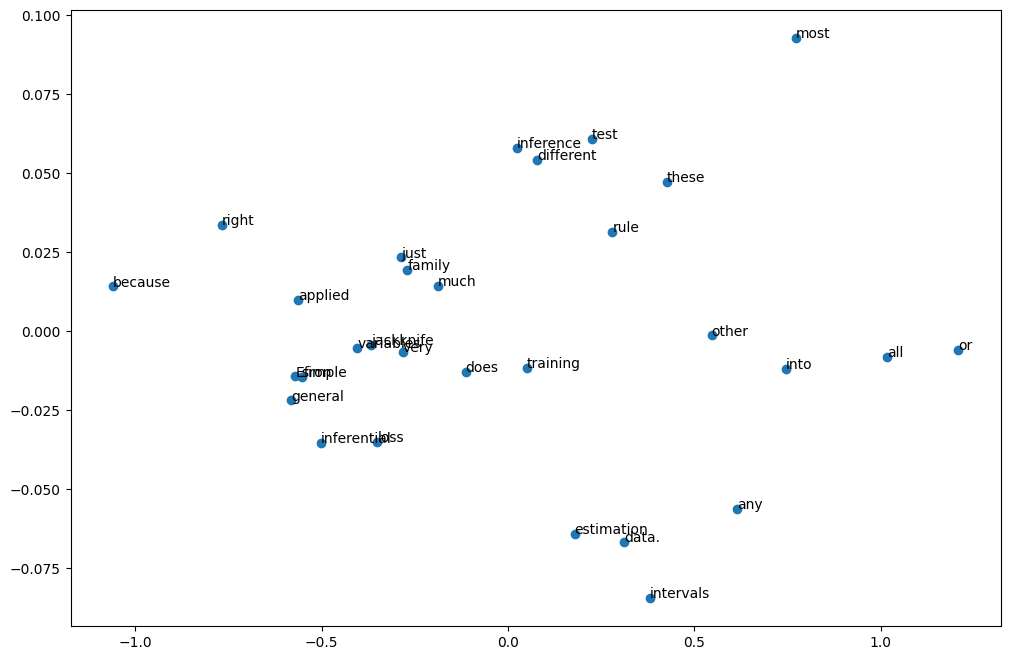

In [16]:
words = [word for word, _ in model.wv.most_similar('statistics', topn=30)]
word_vectors = [model.wv[word] for word in words]

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]))
plt.show()

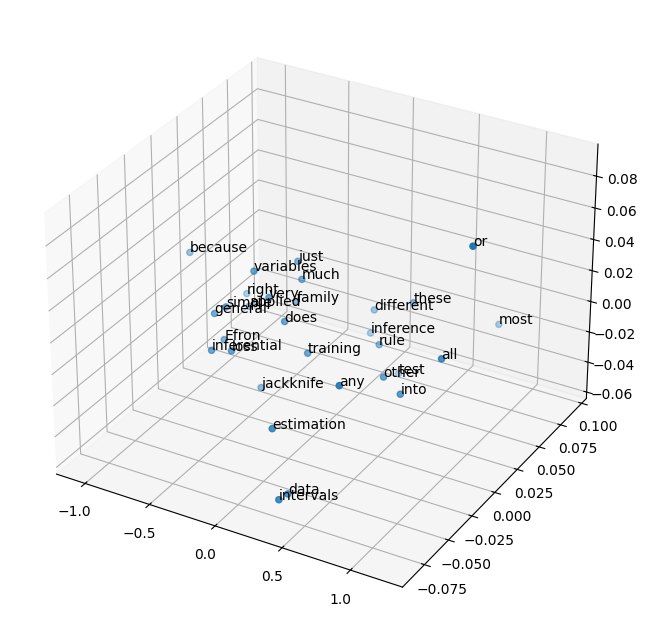

In [17]:
words = [word for word, _ in model.wv.most_similar('statistics', topn=30)]
word_vectors = np.array([model.wv[word] for word in words])

pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(word_vectors)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], reduced_vectors[:, 2])

for i, word in enumerate(words):
    ax.text(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2], word)

plt.show()

Cosine similarity between frequentist and Bayes: 0.9954615831375122
Cosine similarity between objective and subjective: 0.9872759580612183


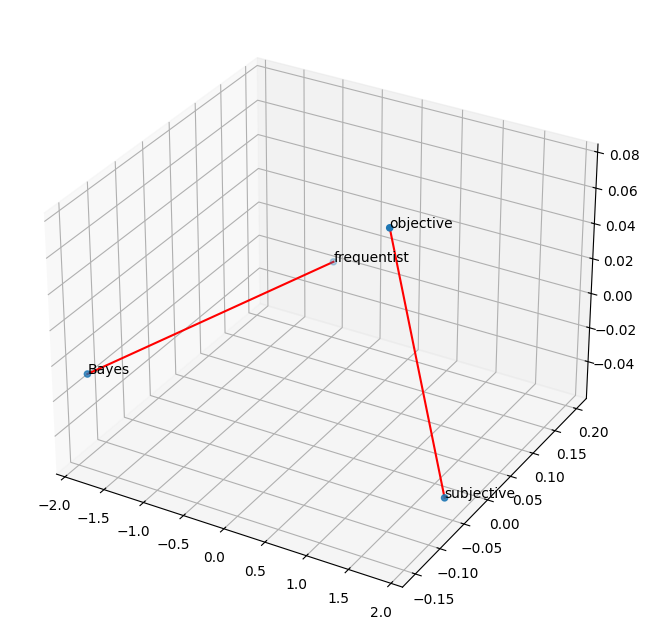

In [18]:
words = ['frequentist', 'Bayes', 'objective', 'subjective'] 

word_vectors = np.array([model.wv[word] for word in words])
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(word_vectors)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], reduced_vectors[:, 2])

pairs = [(0, 1), (2, 3)]
for i, j in pairs:
    ax.plot(
        [reduced_vectors[i, 0], reduced_vectors[j, 0]],
        [reduced_vectors[i, 1], reduced_vectors[j, 1]],
        [reduced_vectors[i, 2], reduced_vectors[j, 2]],
        'r-'
    )

for i, word in enumerate(words):
    ax.text(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2], word)

for i, j in pairs:
    similarity = model.wv.similarity(words[i], words[j])
    print(f"Cosine similarity between {words[i]} and {words[j]}: {similarity}")

plt.show()